# Topic Modelling

## LDA - Latent Drichilet Allocation

In [1]:
#Dependencies
import pandas as pd
import matplotlib.pyplot as plt

#the library for Topic modelling
import gensim
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora, models
import pyLDAvis.gensim #LDA visualization library

from nltk.corpus import stopwords
import nltk
nltk.download('wordnet')
import string
from nltk.stem.wordnet import WordNetLemmatizer
import re

from itertools import chain
import warnings
warnings.simplefilter('ignore')

[nltk_data] Error loading wordnet: hostname
[nltk_data]     'raw.githubusercontent.com' doesn't match
[nltk_data]     'ciupfortigate.lan.ciup.fr'


**Read News articles pickle file**

In [2]:
df = pd.read_csv("./corpus.csv")
print(df.shape)
df.head()

(10000, 4)


,title,site_type,body,id
0,Why does Apple act like Intel is always holdin...,discussions,\nBecause macs don't bring in the profit that ...,76b0891843eb381c4c0e3e5974fd40f2
1,"California reports 585 coronavirus deaths, new...",blogs,"\nCalifornia reports 585 coronavirus deaths, n...",b205f71670059e39e436226fe728fbd6
2,Reset Passcode On iPhone,blogs,\nHome » reset iphone » Reset Passcode On iPho...,15e2fa5f37ad8de40d13ec780cd2c9ce
3,Windows Explorer,discussions,\nWhen I try to open a specific folder which c...,2c9009e582b9fc8744ffcbdc2d329e58
4,Caledon prison may have restrictions eased ami...,news,\nBrian Molefe takes aim at Ramaphosa for Esko...,f2e48d383b36b2eefa09e44ff9ea78e4


# Cleaning and Preprocessing

In [3]:
#clean the data
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^a-z #+_]')

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
#stop = set(stopwords.words('english'))
stop = set(stop_words)
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

def clean(text):
    text = text.lower()
    text = re.sub(REPLACE_BY_SPACE_RE, " ", text)
    text = re.sub(BAD_SYMBOLS_RE, "", text)
    stop_free = ' '.join([word for word in text.lower().split() if (not word in stop and not word == "")])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = ' '.join([lemma.lemmatize(word) for word in punc_free.split() if (len(word) > 1)])
    return normalized.split()

In [4]:
df['text_clean']=df['body'].apply(clean)

In [5]:
for i in range(10000):
    df['text_clean'][i] = gensim.utils.simple_preprocess(str(df['text_clean'][i]), deacc=True)

**Dataframe after cleaning**

In [6]:
df.head()

,title,site_type,body,id,text_clean
0,Why does Apple act like Intel is always holdin...,discussions,\nBecause macs don't bring in the profit that ...,76b0891843eb381c4c0e3e5974fd40f2,"[mac, dont, bring, profit, iphone, market, sha..."
1,"California reports 585 coronavirus deaths, new...",blogs,"\nCalifornia reports 585 coronavirus deaths, n...",b205f71670059e39e436226fe728fbd6,"[california, report, coronavirus, death, new, ..."
2,Reset Passcode On iPhone,blogs,\nHome » reset iphone » Reset Passcode On iPho...,15e2fa5f37ad8de40d13ec780cd2c9ce,"[home, reset, iphone, reset, passcode, iphone,..."
3,Windows Explorer,discussions,\nWhen I try to open a specific folder which c...,2c9009e582b9fc8744ffcbdc2d329e58,"[try, open, specific, folder, contains, word, ..."
4,Caledon prison may have restrictions eased ami...,news,\nBrian Molefe takes aim at Ramaphosa for Esko...,f2e48d383b36b2eefa09e44ff9ea78e4,"[brian, molefe, take, aim, ramaphosa, eskoms, ..."


# Preparing Document-Term Matrix

In [7]:
# Creating the term dictionary of our courpus, where every unique term is assigned an index.
dictionary = corpora.Dictionary(df['text_clean'])
#Total number of non-zeroes in the BOW matrix (sum of the number of unique words per document over the entire corpus).
print(dictionary.num_nnz)

4795897


In [8]:
# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above
doc_term_matrix = [dictionary.doc2bow(doc) for doc in df['text_clean'] ]
#print(len(doc_term_matrix)) = 10000

# LDA model

In [9]:
# Creating the object for LDA model using gensim library
lda = gensim.models.ldamodel.LdaModel

In [10]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [11]:
%time model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=doc_term_matrix, texts=df['text_clean'], start=2, limit=10, step=1)

CPU times: user 15min 28s, sys: 7min 58s, total: 23min 26s
Wall time: 28min 1s


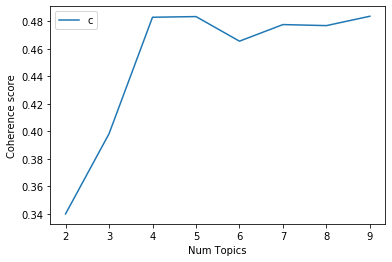

In [13]:
limit=10; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()# Print the coherence scores

In [14]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.34
Num Topics = 3  has Coherence Value of 0.3983
Num Topics = 4  has Coherence Value of 0.4829
Num Topics = 5  has Coherence Value of 0.4834
Num Topics = 6  has Coherence Value of 0.4655
Num Topics = 7  has Coherence Value of 0.4776
Num Topics = 8  has Coherence Value of 0.4768
Num Topics = 9  has Coherence Value of 0.4837


# Building the Topic Model

In [15]:
# Running and Trainign LDA model on the document term matrix.
num_topics = 5
%time ldamodel = lda(doc_term_matrix,num_topics=num_topics,id2word=dictionary)

CPU times: user 1min 26s, sys: 48.1 s, total: 2min 14s
Wall time: 52.4 s


# View the topics in LDA model

In [16]:
ldamodel.print_topics(num_topics=5)

[(0,
  '0.004*"said" + 0.004*"company" + 0.004*"new" + 0.004*"data" + 0.003*"may" + 0.003*"microsoft" + 0.003*"year" + 0.003*"market" + 0.003*"security" + 0.003*"also"'),
 (1,
  '0.013*"casino" + 0.010*"online" + 0.008*"game" + 0.005*"site" + 0.004*"one" + 0.004*"time" + 0.004*"also" + 0.004*"get" + 0.004*"make" + 0.003*"new"'),
 (2,
  '0.005*"one" + 0.005*"name" + 0.004*"like" + 0.004*"time" + 0.003*"new" + 0.003*"year" + 0.003*"would" + 0.003*"people" + 0.003*"also" + 0.003*"business"'),
 (3,
  '0.006*"information" + 0.006*"like" + 0.005*"time" + 0.004*"one" + 0.004*"get" + 0.004*"make" + 0.004*"click" + 0.004*"also" + 0.003*"people" + 0.003*"way"'),
 (4,
  '0.030*"credit" + 0.027*"debt" + 0.019*"counseling" + 0.018*"consumer" + 0.017*"service" + 0.013*"http" + 0.011*"help" + 0.008*"financial" + 0.007*"trump" + 0.007*"program"')]

# Compute Model Perplexity and Coherence Score

In [17]:
print('Perplexity: ', ldamodel.log_perplexity(doc_term_matrix,total_docs=10000))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=ldamodel, texts=df['text_clean'], dictionary=dictionary , coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Perplexity:  -8.609386697813305
Coherence Score:  0.461224219829688


# Visualize the topics-keywordsmodel results

In [18]:
lda_display = pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, dictionary, sort_topics=False, mds='mmds')
pyLDAvis.display(lda_display)

# Finding the dominant topic in each sentence

In [19]:
def format_topics_sentences(ldamodel=ldamodel, corpus=doc_term_matrix, texts=df['text_clean'].values):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamodel, corpus=doc_term_matrix, texts=df['text_clean'].values)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.3423,"said, company, new, data, may, microsoft, year...","[mac, dont, bring, profit, iphone, market, sha..."
1,1,0.0,0.6704,"said, company, new, data, may, microsoft, year...","[california, report, coronavirus, death, new, ..."
2,2,1.0,0.5023,"casino, online, game, site, one, time, also, g...","[home, reset, iphone, reset, passcode, iphone,..."
3,3,0.0,0.6785,"said, company, new, data, may, microsoft, year...","[try, open, specific, folder, contains, word, ..."
4,4,0.0,0.8140,"said, company, new, data, may, microsoft, year...","[brian, molefe, take, aim, ramaphosa, eskoms, ..."
5,5,0.0,0.8767,"said, company, new, data, may, microsoft, year...","[american, dead, covid, death, toll, projected..."
6,6,1.0,0.8170,"casino, online, game, site, one, time, also, g...","[category, blog, considering, time, start, pla..."
7,7,1.0,0.4407,"casino, online, game, site, one, time, also, g...","[hyundai, sonata, find, magic, distinctive, lu..."
8,8,2.0,0.8914,"one, name, like, time, new, year, would, peopl...","[jake, wilson, january, palmer, minutesas, act..."
9,9,1.0,0.6876,"casino, online, game, site, one, time, also, g...","[january, leave, comment, home, fact, worker, ..."


In [23]:
df_dominant_topic["Dominant_Topic"].value_counts()

0.0    3842
2.0    2418
1.0    1499
3.0    1174
4.0    1067
Name: Dominant_Topic, dtype: int64

In [27]:
solution = pd.DataFrame()
solution["id"] = df["id"]
solution["topics"] = df_dominant_topic["Dominant_Topic"]

In [28]:
solution

,id,topics
0,76b0891843eb381c4c0e3e5974fd40f2,0.0
1,b205f71670059e39e436226fe728fbd6,0.0
2,15e2fa5f37ad8de40d13ec780cd2c9ce,1.0
3,2c9009e582b9fc8744ffcbdc2d329e58,0.0
4,f2e48d383b36b2eefa09e44ff9ea78e4,0.0
...,...,...
9995,ba0d3db39704bbd64793d987d41d302e,4.0
9996,ad208127b4296ac9fa0c75bb157aa112,1.0
9997,9f5e021626b945b3b30b4dd692867010,0.0
9998,5c7f2707e1d9ff87a73ba3c6aeda8cf2,3.0


In [33]:
solution.to_csv("./solutions.csv", index=False)